In [17]:
from src import preprocess_util
import json
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
from PIL import Image
import scipy.misc
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torchvision import transforms

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
data_dir = '/workdir/hassony/data'
train_dir = data_dir + '/Training'
save_dir = data_dir + '/storage'

train_df = pd.read_csv('/workdir/hassony/data/Training.csv')

In [19]:
def get_tumor_rec(df, patient_id):
    """
    Returns the target value for the patient 
    (1 or 0 coding for tumor recurrence)
    """
    return int(df[df.Patient_ID==patient_id].Local_tumor_recurrence)

In [69]:
patch_size = 15
patient_patches = preprocess_util.extract_all_patches(train_dir, patch_size)

In [20]:
train_df

,Patient_ID,Local_tumor_recurrence,Gender,Age_at_diagnosis,Race,Tumor_side,Tumor_subsite,T_category,N_category,AJCC_Stage,Pathological_grade,Smoking_status_at_diagnosis,Smoking_Pack-Years,Radiation_treatment_course_duration,Total_prescribed_Radiation_treatment_dose,#_Radiation_treatment_fractions,Induction_Chemotherapy,Concurrent_chemotherapy,KM_Overall_survival_censor
0,1,0,Male,58,White,L,Tonsil,2,0,II,III,Former,5.0,41,66,30,N,N,1
1,2,0,Female,78,White,R,BOT,3,0,III,II,Former,70.0,48,70,35,N,Y,0
2,3,0,Male,57,White,R,Tonsil,1,2b,IV,III,Current,30.0,42,66,30,N,Y,1
3,4,0,Female,56,White,R,BOT,2,2b,IV,III,Never,0.0,45,66,30,N,Y,1
4,5,0,Female,60,White,L,Tonsil,2,2b,IV,II,Never,0.0,54,70,33,N,Y,1
5,6,0,Male,66,White,R,BOT,1,1,III,III,Never,0.0,39,66,30,N,Y,1
6,7,0,Female,72,White,L,BOT,4,0,IV,II,Former,26.0,47,70,33,N,Y,1
7,8,0,Male,77,White,R,Tonsil,1,2a,IV,NaN,Never,0.0,42,70,30,N,N,1
8,9,0,Female,71,White,L,Tonsil,1,2a,IV,I,Former,50.0,43,66,30,N,N,1
9,10,0,Male,50,White,R,BOT,3,3,IV,II,Never,0.0,43,72,40,Y,N,1


In [72]:
pkl.dump(patient_patches, open(save_dir +
                                '/train_patient_patches_size{size}.pkl'.format(size=patch_size),
                                'wb'))
patient_patches = pkl.load( open(save_dir + '/train_patient_patches.pkl', 'rb'))

In [486]:
def get_patients_by_rec(df, patient_list, patient_patches, recurrence_status):
    """
    Returns the sublist of patient_list for which the recurrence_status in df is either 0 or 1
    checks if at least one patch is available by looking up in patient_patches
    """
    patients = []
    for patient in patient_list:
        if (len(patient_patches[patient])>0):
            patient_status = get_tumor_rec(train_df, patient)
            if(patient_status==recurrence_status):
                patients.append(patient)
    return patients

pos_patients = get_patients_by_rec(train_df, patient_patches.keys(), patient_patches, 1)
neg_patients = get_patients_by_rec(train_df, patient_patches.keys(), patient_patches, 0)
def make_train_test_lists(pos_patients, neg_patients):
    nb_pos = np.floor(len(pos_patients)/2)
    nb_neg = np.floor(len(pos_patients)/2)
    split_pos = np.split(np.random.permutation(pos_patients), 2)
    split_neg = np.split(np.random.permutation(neg_patients), 2)
    training_set = list(split_pos[0]) + list(split_neg[0])
    test_set = list(split_pos[1]) + list(split_neg[1])
    return training_set, test_set
    
train_list, test_list = make_train_test_lists(pos_patients, neg_patients)
# print(get_patients_by_rec(train_df, neg_patient_list, patient_patches, 1))

In [490]:
def list_to_tensor(tensor_list):
    """
    Turns a list of tensors into one big tensor
    list's tensors are concatenated on the first dimension
    """
    tensor_nb = len(tensor_list)
    tensor_shape = tensor_list[0].numpy().shape
    tensor = torch.Tensor(np.zeros([tensor_nb, 1] + list(tensor_shape)))
    for idx in range(len(tensor_list)):
        tensor[idx, 0,] = tensor_list[idx]
    return tensor

def create_patch_target(patient_list, patient_patches, patient_df):
    """
    Get all patches as list of tensors and targets as list
    @patient_list contains the list of patients
    @patient_patches is the dictionnary with all patients id as key and patches as values
    @patient_df is the dataframe that contains all patient's info
    @ target_nb
    """
    all_patches = []
    all_targets = []
    for patient in patient_patches:
        patches = torch.Tensor(patient_patches[patient])
        tumor_rec = get_tumor_rec(patient_df, patient)
        if(len(patches)):
            nb_patch = patches.numpy().shape[0]
            for idx_patch in range(nb_patch):
                all_patches.append(patches[idx_patch,:,:])
                all_targets.append(tumor_rec)
    return all_patches, all_targets           

In [491]:
train_patches, train_targets = create_patch_target(train_list, patient_patches, train_df)
test_patches, test_targets = create_patch_target(test_list, patient_patches, train_df)


In [293]:
def get_mean_patch(train_patches):
    train_patches_tensor = list_to_tensor(train_patches)
    mean_patch = torch.mean(train_patch_tensors, 0)
    return mean_patch[0,0,:,:]

mean_patch = get_mean_patch(train_patches)

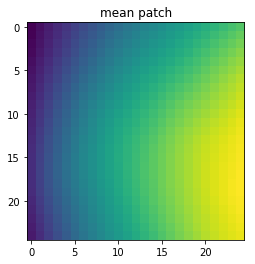

In [294]:
plt.imshow(mean_patch.numpy())
plt.title('mean patch')
plt.show()

In [258]:
def get_indexes_to_remove(targets, disp=False):
    """
    Returns the list of indexes of patches to remove to obtain a balanced data set
    """
    all_pos_indexes = np.where(np.asarray(targets) == 1)[0]
    print('{pos_nb} positive patches'.format(pos_nb=len(all_pos_indexes)))
    all_neg_indexes = np.where(np.asarray(targets) == 0)[0]
    print('{neg_nb} negative patches'.format(neg_nb=len(all_neg_indexes)))
    indexes_to_remove = np.random.choice(all_neg_indexes, len(all_neg_indexes) - len(all_pos_indexes), replace=False)
    return indexes_to_remove



In [267]:
def create_balanced_tensors(train_targets, train_patches):
    train_targets = train_targets[:]
    train_patches = train_patches[:]
    indexes_to_remove = get_indexes_to_remove(train_targets)
    train_targets = np.delete(train_targets, indexes_to_remove)
    train_patches = np.delete(train_patches, indexes_to_remove)
    train_targets = [torch.Tensor([int(tumor_rec), 1 - int(tumor_rec)]) for tumor_rec in train_targets]
    train_targets = list_to_tensor(train_targets)
    train_patches = list_to_tensor(train_patches)
    return train_targets, train_patches

In [272]:
train_target_tensors, train_patch_tensors = create_balanced_tensors(train_targets, train_patches)

130782 positive patches
670859 negative patches


# len(train_targets)


In [273]:
train_patch_tensors.size()

torch.Size([261564, 1, 25, 25])

In [274]:
batch_size = 10
train_dataset = torch.utils.data.TensorDataset(train_patch_tensors, train_target_tensors)
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
print(len(train_loader), 'training samples')

26157 training samples


In [275]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        # self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(F.max_pool2d(x , 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, 64)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x))
        return x

In [414]:
def get_metrics(target, prediction):
    # assert(len(target) == len(prediction), 'target and prediction lists should be of same length')
    sample_nb = len(target)
    confusion_mat = np.zeros([2,2])
    true_positives = sum(1 for tar, pred in zip(target, prediction) if (tar and pred)) 
    true_negatives = sum(1 for tar, pred in zip(target, prediction) if (not tar and not pred)) 
    false_positives = sum(1 for tar, pred in zip(target, prediction) if (not tar and pred)) 
    false_negatives = sum(1 for tar, pred in zip(target, prediction) if (tar and not pred))
    confusion_mat[1, 1] = true_positives
    confusion_mat[0, 0] = true_negatives
    confusion_mat[1, 0] = false_positives
    confusion_mat[0, 1] = false_negatives
    accuracy = (true_positives + true_negatives)/sample_nb
    return confusion_mat, accuracy



In [415]:
def train_net(dataloader, net, loss_criterion, mean_patch, epochNb, optimizer):
    running_loss = 0.0
    prediction = []
    target = []
    for i, data_item in enumerate(dataloader, 0):
        if (i<400):
            # get the inputs
            inputs, labels = data_item

            # Remove mean patch from current patch
            inputs = inputs - mean_patch.repeat(inputs.size()[0], 1, 1, 1)
            labels = labels.squeeze()
            
            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)

            for label in labels:
                if(label.data[0]==1):
                    target.append(1)
                else:
                    target.append(0)
                
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
        #         print('output sizes')
        #         print(outputs.data.numpy())
        #         print('label sizes')
        #         print(labels.data.numpy())
            loss = loss_criterion(outputs, labels)
            loss.backward()        
            optimizer.step()
            for output in outputs:
                if(output.data[0]>0.5):
                    prediction.append(1)
                else:
                    prediction.append(0)
            running_loss += loss.data[0]
    return prediction, target, running_loss


In [416]:
def simulation(dataloader, net, loss_criterion, mean_patch, epochNb, learning_rate):
    train_losses = np.zeros(epochNb)
    train_accuracies = np.zeros(epochNb)
    optimizer = torch.optim.Adam(net.parameters(), learning_rate)
    for epoch in range(epochNb): # loop over the dataset multiple times
        
        # train
        prediction, target, train_loss = train_net(dataloader, net, loss_criterion, mean_patch,
                                                   epochNb, optimizer)
        conf_mat, train_acc = get_metrics(target, prediction)
        train_losses[epoch] = train_loss
        
        # Save results
        train_accuracies[epoch] = train_acc
        train_losses[epoch] = train_loss
        
        # print epoch train results
        print('Training loss: {los}'.format(los=train_loss))
        print('Training confusion matrix')
        print(conf_mat)
        print('Training accuracy : ', train_acc)
    return train_losses

In [417]:
model = Net()

bce_criterion = nn.BCELoss()
epoch = 15
learning_rate = 0.0001
momentum = 0.9
train_losses = simulation(train_loader, model, bce_criterion, mean_patch, epoch, learning_rate)

Training loss: 404.92677038908005
Training confusion matrix
[[ 1568.  1729.]
 [  414.   289.]]
Training accuracy :  0.46425
Training loss: 289.51971247792244
Training confusion matrix
[[ 1748.  1691.]
 [  251.   310.]]
Training accuracy :  0.5145
Training loss: 275.6636660993099
Training confusion matrix
[[ 1747.  1548.]
 [  273.   432.]]
Training accuracy :  0.54475
Training loss: 268.38449189066887
Training confusion matrix
[[ 1562.  1289.]
 [  365.   784.]]
Training accuracy :  0.5865
Training loss: 263.1803034543991
Training confusion matrix
[[ 1487.  1135.]
 [  440.   938.]]
Training accuracy :  0.60625
Training loss: 251.52391742169857
Training confusion matrix
[[ 1468.   959.]
 [  507.  1066.]]
Training accuracy :  0.6335
Training loss: 245.95740212500095
Training confusion matrix
[[ 1381.   809.]
 [  572.  1238.]]
Training accuracy :  0.65475
Training loss: 241.91918003559113
Training confusion matrix
[[ 1373.   754.]
 [  597.  1276.]]
Training accuracy :  0.66225
Training loss

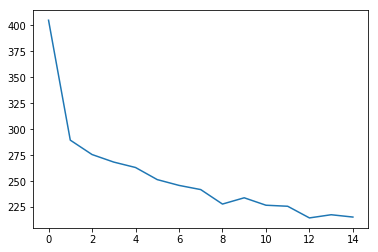

In [419]:
plt.plot(train_losses)
plt.show()